In [1]:
#!pip install pandas numpy yfinance scipy matplotlib

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import datetime as dt

In [3]:
tickers = ['^TNX', 'GLD', 'CL=F', 'ZF=F', 'ZL=F', 'CT=F', 'ARION.IC', 'EIK.IC', 'FESTI.IC', 'EIM.IC', 'AMRQ.L', 'BRIM.IC', 'SJOVA.IC', 'HAGA.IC']
spy_ticker = 'SPY'

start_date = '2023-01-01'
end_date = '2024-12-31'

In [4]:
df = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
spy_df = yf.download(spy_ticker, start=start_date, end=end_date)['Adj Close']

[*********************100%***********************]  14 of 14 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
print(df.head())
print(spy_df.head())
df.isnull().sum()

Ticker                     AMRQ.L    ARION.IC    BRIM.IC       CL=F  \
Date                                                                  
2023-01-02 00:00:00+00:00     NaN  131.548325  88.220406        NaN   
2023-01-03 00:00:00+00:00    41.5  131.991241  87.732994  76.930000   
2023-01-04 00:00:00+00:00    42.0  131.548325  88.220406  72.839996   
2023-01-05 00:00:00+00:00    42.0  131.105392  88.220406  73.669998   
2023-01-06 00:00:00+00:00    42.0  131.105392  88.220406  73.769997   

Ticker                          CT=F     EIK.IC      EIM.IC    FESTI.IC  \
Date                                                                      
2023-01-02 00:00:00+00:00        NaN  10.994337  468.101196  177.216995   
2023-01-03 00:00:00+00:00  83.139999  10.994337  472.645874  178.185394   
2023-01-04 00:00:00+00:00  80.440002  10.899558  481.735229  178.185394   
2023-01-05 00:00:00+00:00  82.580002  10.994337  481.735229  177.216995   
2023-01-06 00:00:00+00:00  85.680000  10.994337  481

Ticker
AMRQ.L      11
ARION.IC    17
BRIM.IC     17
CL=F        14
CT=F        13
EIK.IC      17
EIM.IC      17
FESTI.IC    17
GLD         14
HAGA.IC     17
SJOVA.IC    16
ZF=F        13
ZL=F        14
^TNX        14
dtype: int64

In [6]:
returns = df.pct_change().dropna()
monthly = df.resample('M').last()
monthly_returns = monthly.pct_change().dropna()
spy_returns = spy_df.pct_change().dropna()

/var/folders/nm/qtdl4w8s71x9hxyd6g7xdhkw0000gn/T/ipykernel_19102/3365720372.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = df.pct_change().dropna()
/var/folders/nm/qtdl4w8s71x9hxyd6g7xdhkw0000gn/T/ipykernel_19102/3365720372.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.resample('M').last()


In [7]:
print(spy_returns.head())
print(returns.head())

Date
2023-01-04    0.007720
2023-01-05   -0.011413
2023-01-06    0.022932
2023-01-09   -0.000567
2023-01-10    0.007013
Name: Adj Close, dtype: float64
Ticker                       AMRQ.L  ARION.IC   BRIM.IC      CL=F      CT=F  \
Date                                                                          
2023-01-04 00:00:00+00:00  0.012048 -0.003356  0.005556 -0.053165 -0.032475   
2023-01-05 00:00:00+00:00  0.000000 -0.003367  0.000000  0.011395  0.026604   
2023-01-06 00:00:00+00:00  0.000000  0.000000  0.000000  0.001357  0.037539   
2023-01-09 00:00:00+00:00  0.000000  0.020270  0.000000  0.011658  0.006303   
2023-01-10 00:00:00+00:00  0.000000  0.006623  0.000000  0.006566 -0.016933   

Ticker                       EIK.IC    EIM.IC  FESTI.IC       GLD   HAGA.IC  \
Date                                                                          
2023-01-04 00:00:00+00:00 -0.008621  0.019231  0.000000  0.009412  0.006993   
2023-01-05 00:00:00+00:00  0.008696  0.000000 -0.005435 -

In [8]:
td = 252 # no. trading days
window = 40
# daily mean returns
returns_daily_mean = returns.mean()
# annual returns
annual_returns = (1 + returns_daily_mean) ** td - 1
# how do the assets move in relations to each other
# diagonal - variances, np.sqrt(variance) would give the volatility
# off-diagonal - covariance, how do the assets move in relations to each other?
returns_cov_matrix = returns.cov() * td 


In [9]:
def get_risk_free(ticker):
    risk_free_ic = 0.0825
    risk_free_usa = 0.0479
    rf = risk_free_ic if ticker.endswith(".IC") else risk_free_usa
    return rf

In [10]:
# sharpe = (returns - risk free) / volatility
sharpes = {}

for t in tickers:
    risk_free = get_risk_free(t)
    variance = returns_cov_matrix.loc[t, t] # find the variance
    volatility = np.sqrt(variance)
    ret = annual_returns[t]
    sharpe_ratio = (ret - risk_free) / volatility
    sharpes[t] = sharpe_ratio
sharpes_df = pd.DataFrame.from_dict(sharpes, orient='index', columns=['Sharpe ratio'])
sharpes_df

,Sharpe ratio
^TNX,0.317301
GLD,1.041155
CL=F,-0.127266
ZF=F,-1.084428
ZL=F,-0.727281
CT=F,-0.435711
ARION.IC,0.315574
EIK.IC,0.330747
FESTI.IC,1.035906
EIM.IC,-0.683364


In [11]:
def portfolio_return(weights, annual_returns):
    return np.sum(weights * annual_returns)

In [12]:
def portfolio_vol(weights, returns_cov_matrix):
    cov_weights = np.dot(returns_cov_matrix, weights)
    variance = np.dot(weights.T, cov_weights)
    volatility = np.sqrt(variance)
    return volatility

In [13]:
def negative_sharpe_ratio(weights, annual_returns, returns_cov_matrix, risk_free, prev_weights=None):
    port_ret = portfolio_return(weights, annual_returns)
    port_vol = portfolio_vol(weights, returns_cov_matrix)
    # using minimization, so - to find the minimum -maximum sr portfolio combination
    sharpe_ratio -(port_ret - risk_free) / port_vol
    penalty = 0
    if prev_weights is not None:
        penalty = np.sum(np.abs(weights - prev_weights))  # Sum of absolute differences
    pw = 0.9
    return sharpe_ratio + (pw * penalty)

In [14]:
def best_local_minimum(inits, bounds, constraints, prev_weight=None):
    best_result = None
    best_fun = None
    for _ in range(inits): # iterate x many times to avoid a bad local minimum
        x0 = np.array([
                np.random.uniform(low=b[0], high=b[1]) for b in bounds
            ]) # random starting point of weights for different minimums
        risk_free = np.sum([get_risk_free(t) * x0[i] for i, t in enumerate(tickers)])
        opt_portfolio = minimize(
            fun=negative_sharpe_ratio,
            x0=x0,
            args=(annual_returns, returns_cov_matrix, risk_free, prev_weight),
            method='SLSQP',
            bounds=bounds,
            constraints=constraints
        )
        if best_fun is None or opt_portfolio.fun < best_fun:
            best_fun = opt_portfolio.fun
            best_result = opt_portfolio.x
    return best_result

In [15]:
inits = 5
# Constraints: sum of weights = 1
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(np.abs(w)) - 1},
               {'type': 'eq', 'fun': lambda w: w[0] + w[1] + w[2] + w[3] + w[4] + w[5] - 0.4}) # optional, 40% to safer assets
# upper and lower bounds, [0] = -1 for short, < -1 for leveraged shorts allowed
# same for [1], 1 for 100% long boundary and ex. 5, for 5x allocation of capital
bounds = tuple((0, 1) for _ in range(len(tickers))) # only allow 100% of capital allocation and no shorts for this
optimal_portfolio_weights = best_local_minimum(inits, bounds, constraints)

In [16]:
portfolio_weights_df = pd.DataFrame({
    'Ticker': tickers,
    'Weight': optimal_portfolio_weights
})
portfolio_weights_df


,Ticker,Weight
0,^TNX,0.000000e+00
1,GLD,0.000000e+00
2,CL=F,5.551115e-17
3,ZF=F,6.059554e-02
4,ZL=F,3.394045e-01
5,CT=F,0.000000e+00
6,ARION.IC,7.427777e-04
7,EIK.IC,0.000000e+00
8,FESTI.IC,0.000000e+00
9,EIM.IC,3.656982e-01


In [17]:
optimal_return = portfolio_return(np.array(optimal_portfolio_weights), annual_returns)
optimal_risk = portfolio_vol(optimal_portfolio_weights, returns_cov_matrix)
risk_free = np.sum([get_risk_free(t) * optimal_portfolio_weights[i] for i, t in enumerate(tickers)])
optimal_sr = (optimal_return - risk_free) / optimal_risk

print(f"Annual Return: {optimal_return:.2%}")
print(f"Risk free rate: {risk_free:.2%}")
print(f"Annual Volatility: {optimal_risk:.2%}")
print(f"Sharpe Ratio: {optimal_sr:.2f}")


Annual Return: 10.11%
Risk free rate: 6.87%
Annual Volatility: 13.15%
Sharpe Ratio: 0.25


In [18]:
portfolio_daily_returns = returns.dot(optimal_portfolio_weights)
portfolio_cumulative_returns = (1 + portfolio_daily_returns).cumprod()
spy_cum = (1 + spy_returns).cumprod()

In [19]:
window_size = 5  # weekly
num_windows = len(returns) - window_size + 1

In [20]:
def optimize_window(data, prev_weight):
    mean_returns = data.mean()
    cov_matrix = data.cov()    
    return best_local_minimum(inits, bounds, constraints, prev_weight)
    return result.x

In [21]:
# Store the optimized weights for each window
optimized_monthly_weights = []
prev_weight = None
for i in range(num_windows):
    window_data = returns.iloc[i:i+window_size]
    window_weights = optimize_window(window_data, prev_weight)
    optimized_monthly_weights.append(window_weights)
    prev_weight = window_weights


In [22]:
aggregated_weights = np.mean(optimized_monthly_weights, axis=0)
aggregated_weights_df = pd.DataFrame({
    'Ticker': tickers,
    'Weight': aggregated_weights
})
aggregated_weights_df

,Ticker,Weight
0,^TNX,0.276535
1,GLD,0.009855
2,CL=F,0.000044
3,ZF=F,0.000064
4,ZL=F,0.113458
5,CT=F,0.000044
6,ARION.IC,0.192297
7,EIK.IC,0.000039
8,FESTI.IC,0.000036
9,EIM.IC,0.000051


In [23]:
aggr_return = portfolio_return(aggregated_weights, annual_returns)
aggr_risk = portfolio_vol(aggregated_weights, returns_cov_matrix)
risk_free = np.sum([get_risk_free(t) * aggregated_weights[i] for i, t in enumerate(tickers)])
aggr_sr = (aggr_return - risk_free) / aggr_risk

print(f"Annual Return: {aggr_return:.2%}")
print(f"Risk free rate: {risk_free:.2%}")
print(f"Annual Volatility: {aggr_risk:.2%}")
print(f"Sharpe Ratio: {aggr_sr:.2f}")

Annual Return: 22.54%
Risk free rate: 6.09%
Annual Volatility: 11.52%
Sharpe Ratio: 1.43


In [24]:
final_portfolio_returns = returns.dot(aggregated_weights)
final_cumulative_returns = (1 + final_portfolio_returns).cumprod()
print(final_portfolio_returns)

Date
2023-01-04 00:00:00+00:00    0.001966
2023-01-05 00:00:00+00:00    0.002194
2023-01-06 00:00:00+00:00   -0.003142
2023-01-09 00:00:00+00:00    0.000074
2023-01-10 00:00:00+00:00    0.002459
                               ...   
2024-12-23 00:00:00+00:00    0.017689
2024-12-24 00:00:00+00:00   -0.006812
2024-12-26 00:00:00+00:00   -0.000527
2024-12-27 00:00:00+00:00    0.005079
2024-12-30 00:00:00+00:00   -0.001767
Length: 513, dtype: float64


In [25]:
spy_annual_return = (1 + spy_returns.mean()) ** td - 1
spy_risk = spy_returns.std() * np.sqrt(252)
spy_risk_free = get_risk_free('')
spy_sr = (spy_annual_return - spy_risk_free) / spy_risk

print(f"Annual Return: {spy_annual_return:.2%}")
print(f"Risk free rate: {spy_risk_free:.2%}")
print(f"Annual Volatility: {spy_risk:.2%}")
print(f"Sharpe Ratio: {spy_sr:.2f}")

Annual Return: 27.30%
Risk free rate: 4.79%
Annual Volatility: 12.83%
Sharpe Ratio: 1.75


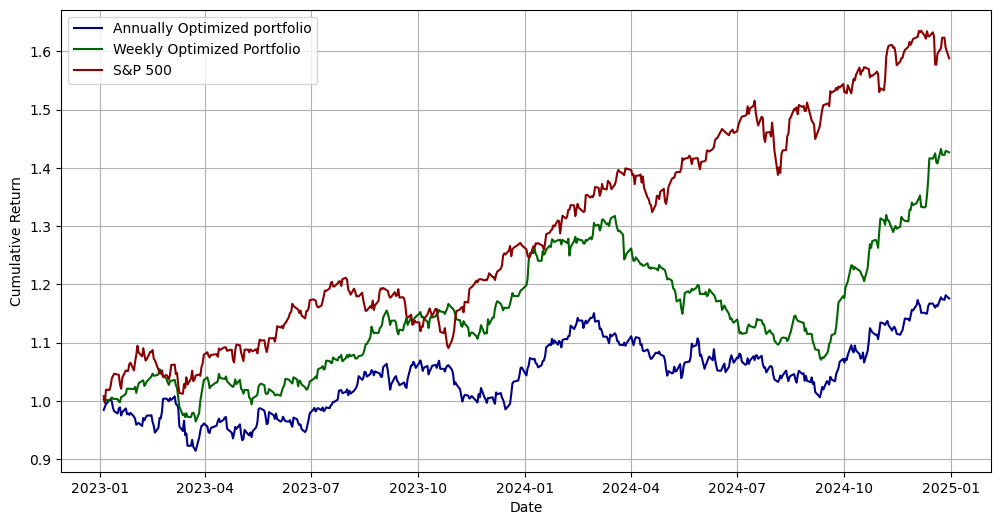

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(portfolio_cumulative_returns.index, portfolio_cumulative_returns, color="darkblue")
plt.plot(final_cumulative_returns.index, final_cumulative_returns, color="darkgreen")
plt.plot(spy_cum.index, spy_cum, color="darkred")
plt.legend(['Annually Optimized portfolio', 'Weekly Optimized Portfolio', 'S&P 500'])
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.show()

In [27]:
start_date2 = '2021-07-01'
end_date2 = '2022-12-31'

In [28]:
df2 = yf.download(tickers, start=start_date2, end=end_date2)['Adj Close']
spy_df2  = yf.download(spy_ticker, start=start_date2, end=end_date2)['Adj Close']

[*********************100%***********************]  14 of 14 completed
[*********************100%***********************]  1 of 1 completed


In [29]:
returns2 = df2.pct_change().dropna()
spy_returns2 = spy_df2.pct_change().dropna()
returns_daily_mean2 = returns2.mean()
# annual returns
annual_returns2 = (1 + returns_daily_mean2) ** td - 1
returns_cov_matrix2 = returns2.cov() * td 

/var/folders/nm/qtdl4w8s71x9hxyd6g7xdhkw0000gn/T/ipykernel_19102/1376360082.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns2 = df2.pct_change().dropna()


In [30]:
aggr_return2 = portfolio_return(aggregated_weights, annual_returns2)
aggr_risk2 = portfolio_vol(aggregated_weights, returns_cov_matrix2)
risk_free = np.sum([get_risk_free(t) * aggregated_weights[i] for i, t in enumerate(tickers)])
aggr_sr2 = (aggr_return2 - risk_free) / aggr_risk2

print(f"Annual Return: {aggr_return2:.2%}")
print(f"Risk free rate: {risk_free:.2%}")
print(f"Annual Volatility: {aggr_risk2:.2%}")
print(f"Sharpe Ratio: {aggr_sr2:.2f}")

Annual Return: 37.41%
Risk free rate: 6.09%
Annual Volatility: 17.28%
Sharpe Ratio: 1.81


In [31]:
optimal_return2 = portfolio_return(np.array(optimal_portfolio_weights), annual_returns2)
optimal_risk2 = portfolio_vol(optimal_portfolio_weights, returns_cov_matrix)
risk_free = np.sum([get_risk_free(t) * optimal_portfolio_weights[i] for i, t in enumerate(tickers)])
optimal_sr2 = (optimal_return2 - risk_free) / optimal_risk2

print(f"Annual Return: {optimal_return2:.2%}")
print(f"Risk free rate: {risk_free:.2%}")
print(f"Annual Volatility: {optimal_risk2:.2%}")
print(f"Sharpe Ratio: {optimal_sr2:.2f}")

Annual Return: 28.98%
Risk free rate: 6.87%
Annual Volatility: 13.15%
Sharpe Ratio: 1.68


In [32]:
final_portfolio_returns2 = returns2.dot(aggregated_weights)
final_cumulative_returns2 = (1 + final_portfolio_returns2).cumprod()
spy_cum2 = (1 + spy_returns2).cumprod()

In [33]:
portfolio_daily_returns2 = returns2.dot(optimal_portfolio_weights)
portfolio_cumulative_returns2 = (1 + portfolio_daily_returns2).cumprod()

****Performance of weights for a different period****

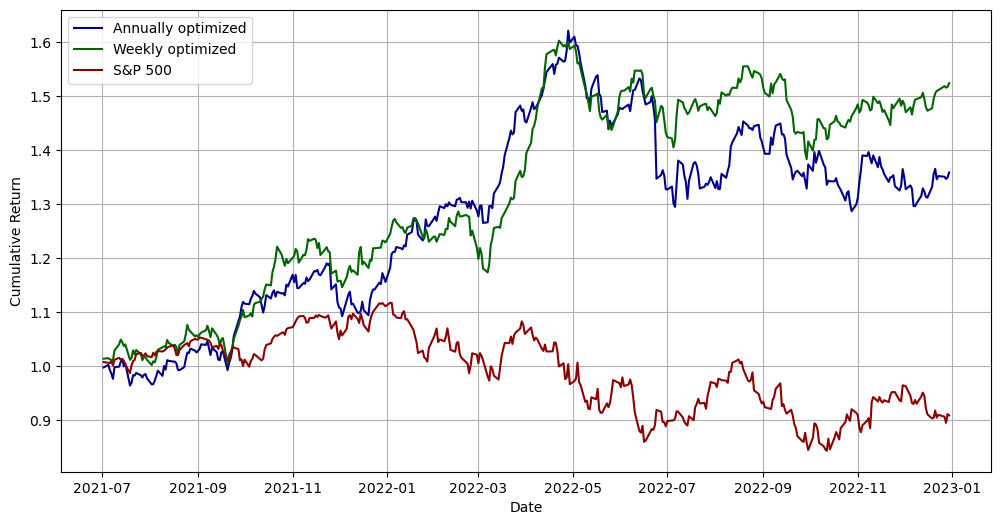

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(portfolio_cumulative_returns2.index, portfolio_cumulative_returns2, color="darkblue")
plt.plot(final_cumulative_returns2.index, final_cumulative_returns2, color="darkgreen")
plt.plot(spy_cum2.index, spy_cum2, color="darkred")
plt.legend(['Annually optimized', 'Weekly optimized', 'S&P 500'])
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.show()